# Regularized logistic regression

In this notebook, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the test results for some microchips on two dierent tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# change directory to the location containing the data for the notebook
os.chdir('.\JupyterNotebooks\AndrewNG_ML\data')
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '.\\JupyterNotebooks\\AndrewNG_ML\\data'

## Load the input data

In [142]:
data = pd.read_csv('ex2data2.txt', names=['Test1', 'Test2', 'Status'])
# input feature matrix containing two column vectors representing the score of the two tests
X = data.iloc[:, 0:2].values
# output variable vector representing whether the chip was accepted or rejected. Note this is a numpy 1d array
y1d = data.iloc[:, 2].values
data.head()

,Test1,Test2,Status
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


## Visualize the raw input data

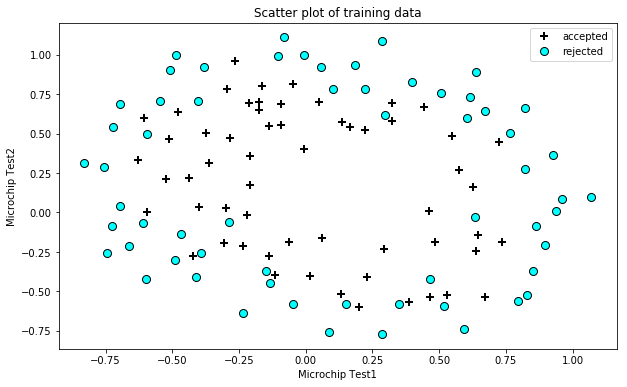

In [173]:
def plot_raw_data(X, y):
    accepted = y == 1
    X_accepted = X[accepted]
    X_rejected = X[~accepted]
    fig, ax = plt.subplots(figsize=(10,6)) 
    plt.plot(X_accepted[:, 0], X_accepted[:, 1], '+', ms=8, mew=2, color='black', label='accepted')
    plt.plot(X_rejected[:, 0], X_rejected[:, 1], 'o', ms=8, mew=1, mfc='cyan', mec='k',label='rejected')
    plt.xlabel('Microchip Test1')
    plt.ylabel('Microchip Test2')
    return fig, ax
    
fig, ax = plot_raw_data(X, y1d)    
plt.title('Scatter plot of training data')
plt.legend()
plt.show()

The plot above shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-
forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

## Feature mapping

One way to fit the data better is to create more features from each data point.We will map the features into all polynomial terms of x1 and x2 up to the sixth power.As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier,it also more susceptible to overfitting. In the next parts of the exercise, you
will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

In [155]:
def get_degree_pairs(degree):
    degree1 = 0
    degree2 = degree
    list_degree_pairs = []
    while degree1 <= degree and degree2 >= 0:
        if (degree1 + degree2) == degree:
            list_degree_pairs.append((degree1, degree2))
            degree1 += 1
            degree2 -= 1
    return list_degree_pairs

def feature_mapping(x1, x2, degree):    
    ones = np.ones(len(x1)).reshape(-1, 1)    
    out_X = np.concatenate((ones, x1.reshape(-1, 1)), axis=1)
    out_X = np.concatenate((out_X, x2.reshape(-1, 1)), axis=1)
    degree_counter = 2
    while degree_counter <= degree:
        list_degree_pairs = get_degree_pairs(degree_counter)
        for degree_pair in list_degree_pairs:
            # We are doing an element wise multiplication of the two vectors of size mx1 to create polynomial features
            temp = np.multiply(x1**degree_pair[0], x2**degree_pair[1])            
            out_X = np.concatenate((out_X, temp.reshape(-1, 1)), axis=1)
        degree_counter += 1
    return out_X

In [156]:
# test 1 scores
x1 = X[:, 0]
# test 2 scores
x2 = X[:, 1]
X_poly = feature_mapping(x1, x2, 6)

## Cost function and gradient

Now you will implement code to compute the cost function and gradient for regularized logistic regression. The regularized cost function is defined as:

$$
J\left(\theta\right) = \frac{1}{m}\sum_{i=1}^m\left[-y^\left(i\right)\log \left(h_\theta\left(x^\left(i\right)\right)\right) - \left(1-y^\left(i\right)\right)\log \left(1 - h_\theta\left(x^\left(i\right)\right)\right) \right] + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2
$$

Note that you should not regularize the parameter $\theta_0$. Hence, you should not be regularizing the theta(0) parameter (which corresponds to $\theta_0$) in the code.

In [157]:
# import the sigmoid function available in scipy
from scipy.special import expit

def cost_function_reg(theta, X, y, lamda):
    theta = theta.reshape(-1, 1)
    h = expit(np.dot(X, theta))
    m = len(X)    
    # J is a scalar 
    J = -(1/m) * (np.dot(np.transpose(y), np.log(h)) + np.dot(np.transpose(1 - y), np.log(1 - h))) + (lamda/(2*m)) * np.sum(theta[1:]**2)
    grad = (1 / m) * np.dot(np.transpose(X), (h - y))   
    #print(grad.shape)
    #print(grad)
    grad_reg = (lamda / m) * theta[1:]    
    #print(grad_reg.shape)
    grad_reg = np.insert(grad_reg, 0, 0)    
    #print(grad_reg.shape)
    grad = grad + grad_reg.reshape(-1, 1)
    return J, grad

The regularized cost function should return a cost of 0.693 using an initial theta value of all zeros

In [158]:
n = X_poly.shape[1]
initial_theta = np.zeros(n)
y = y1d.reshape(-1, 1)
cost, grad = cost_function_reg(initial_theta, X_poly, y, 1)
print(cost[0][0])
print('Gradient at initial theta (zeros) - first five values only:')
# format. * unpacks the arguments so if there are, say 4 placeholders and 4 elements in your list, then format unpacks the args and fills the slots.
print('{:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(*grad.flatten()[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')

0.6931471805599453
Gradient at initial theta (zeros) - first five values only:
0.0085 0.0188 0.0001 0.0377 0.0115
Expected gradients (approx) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]



## Learning parameters using fminunc 
optimization solver that finds the minimum of an unconstrained function

In [179]:
from scipy.optimize import minimize

def get_optimized_cost_theta(lamda):
    options= {'maxiter': 100}
    opt = minimize(fun=cost_function_reg, x0=initial_theta, args=(X_poly, y, lamda), jac=True, method='TNC', options=options)
    optimized_theta = opt.x
    cost_optimized = opt.fun
    return cost_optimized, optimized_theta    

opt_cost1, opt_theta1 = get_optimized_cost_theta(1.00)    
print('Optimized cost: {}'.format(opt_cost))
print('Optimized theta: {}'.format(opt_theta))

Optimized cost: [[0.52900273]]
Optimized theta: [ 1.27271024  0.62529964  1.18111686 -1.43166924 -0.91743188 -2.01987397
 -0.1751629  -0.35725404 -0.36553118  0.12393229 -1.19271299 -0.27469166
 -0.61558558 -0.05098418 -1.45817008 -0.45645982 -0.29539513 -0.27778947
 -0.04466179 -0.20603302 -0.24217841 -0.92467489 -0.14389149 -0.32742403
  0.01555759 -0.29244865  0.02779373 -1.04319154]


In [180]:
def predict(theta, X):
    product = np.dot(X, theta)
    classifier = lambda item: 1 if item > 0 else 0
    v_classifier = np.vectorize(classifier)
    return v_classifier(product)

predicted_y = predict(optimized_theta, X_poly)
is_correct = predicted_y == y1d
accuracy = len(predicted_y[is_correct]) / len(is_correct)
print('Accuracy of predictions: {}'.format(round(accuracy, 2)))

Accuracy of predictions: 0.83


## Plotting the decision boundary

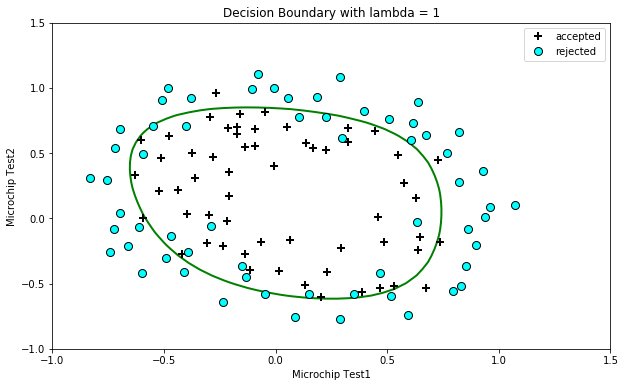

In [186]:
def plot_decision_boundary(theta, X, y):
    if X.shape[1] <= 3:
        plot_x = np.array([np.min(X[:, 1]), np.max(X[:, 1])])
        plot_y = -1 / theta[2] * (theta[1] * plot_x + theta[0])
        plt.plot(plot_x, plot_y, label='decision boundary')
        plt.legend()
        plt.show()
    else:
        # Here is the grid range
        x1 = np.linspace(-1, 1.5, 50);
        #print(x1)
        x2 = np.linspace(-1, 1.5, 50);
        #print(x2)
        z = np.zeros((len(x1), len(x2)));
        # Evaluate z = theta*x over the grid
        for i in range(1, len(x1)):
            for j in range(1, len(x2)):
                z[i,j] = np.dot(feature_mapping(np.array([x1[i]]), np.array([x2[j]]), 6), theta)        
        z = np.transpose(z)
        plt.contour(x1, x2, z, levels=[0], linewidths=2, colors='g')
        #plt.contourf(x1, x2, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.4)

plot_raw_data(X, y1d)  
plot_decision_boundary(opt_theta1, X_poly, y)
plt.title('Decision Boundary with lambda = 1')
plt.legend()
plt.show()

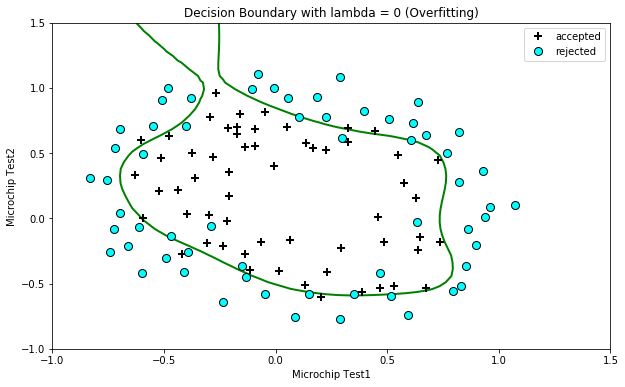

In [190]:
opt_cost100, opt_theta100 = get_optimized_cost_theta(0.00)    
plot_raw_data(X, y1d)
plot_decision_boundary(opt_theta100, X_poly, y)
plt.title('Decision Boundary with lambda = 0 (Overfitting)')
plt.legend()
plt.show()

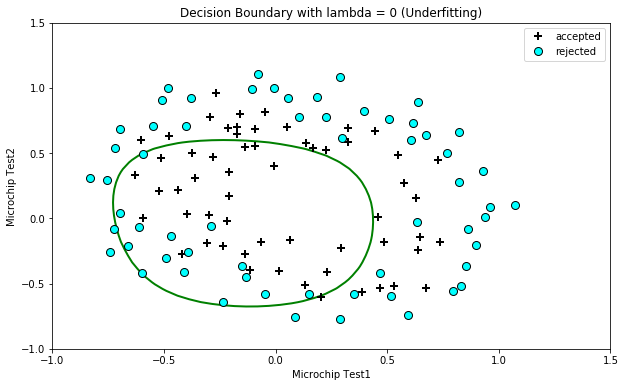

In [191]:
opt_cost100, opt_theta100 = get_optimized_cost_theta(100.00)    
plot_raw_data(X, y1d)
plot_decision_boundary(opt_theta100, X_poly, y)
plt.title('Decision Boundary with lambda = 0 (Underfitting)')
plt.legend()
plt.show()